In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

from mixture import mixture_model, Mixture

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
data=np.load("../data/data.npz")

xtr1 = data["xtr1"]
xtr2 = data["xtr2"]
xte1 = data["xte1"]
xte2 = data["xte2"]

In [7]:
def train(X):
    best_all = [float('-inf')] * 20
    best_models = [None] * 20
    
    N, D = X.shape

    for K in range(1, 21):
        # Train model 10 times
        for i in range(10):
            mm = mixture_model(K=K)

            mm.fit(X, mu_init=None, b_init=None, pi_init=None, step=0.1, epochs=20)

            val = mm.marginal_likelihood(X)

            if val > best_all[K-1]:
                best_all[K-1] = val
                best_models[K-1] = mm

        print(K, best_all[K-1])

    return best_all, best_models

In [8]:
tr_vals, tr_models = train(xtr2)

1 -7324.89661668294
2 -6658.583092653651
3 -6088.610452772076
4 -5399.283521932869
5 -5019.862647628986
6 -4616.00778532137
7 -4298.001806140083
8 -4044.3555063095782
9 -3867.5708435600673
10 -3874.8645426055427
11 -3801.700955386079
12 -3762.8857795360423
13 -3758.0410462675945
14 -3759.9438341925024
15 -3779.2822490454187
16 -3740.886411369898
17 -3769.1752159989946
18 -3711.527365686322
19 -3749.133675071745
20 -3745.4704046748416


In [33]:
mean_vals = []

for model in tr_models:
    imputed = model.impute(xtr2)
    assert imputed.shape == xtr2.shape
    
    nan_mask = np.isnan(xtr2)
    missing_vals = nan_mask * imputed

    X_ans = np.nan_to_num(xte2)
    
    nonzero = np.count_nonzero(X_ans)
    
    mean_val = np.abs(X_ans - missing_vals).sum() / nonzero
    mean_vals.append(mean_val)

mean_vals

[0.8130451113399197,
 0.6913816561689267,
 0.6476574180913176,
 0.5454624828368659,
 0.5067920515360808,
 0.46012109298682097,
 0.43028965066791686,
 0.3903888804439686,
 0.3623325033003723,
 0.36768264349684543,
 0.3576335326687837,
 0.36133054190069486,
 0.36030685158701387,
 0.36229689779052526,
 0.3604994915917089,
 0.3577984488963675,
 0.3618621740709652,
 0.3594797207496135,
 0.3580131151037871,
 0.35725233217564256]

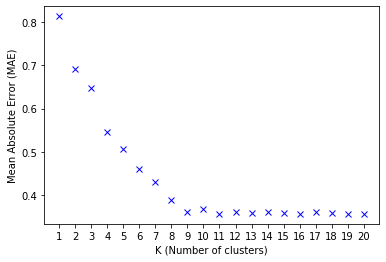

In [34]:
plt.xlabel('K (Number of clusters)')
plt.ylabel('Mean Absolute Error (MAE)')

x = np.linspace(1, 20, num=20)

plt.xticks(range(1, 21))
plt.plot(x, mean_vals, 'bx')

plt.show()

In [ ]:
test_mgl = []
for model in tr_models:
    test_mgl.append(model.forward(torch.from_numpy(xte1)))

test_mgl

In [ ]:
plt.xlabel('K (Number of clusters)')
plt.ylabel('Log Marginal Likelihood')

x = np.linspace(1, 20, num=20)

plt.xticks(range(1, 21))
plt.plot(x, tr_vals, 'rx', label='Train marginal log likelihood')
plt.plot(x, test_mgl, 'bx', label='Test marginal log likelihood')
plt.legend()

plt.show()

In [ ]:
tr_c_vals, tr_c_models = train(xtr1)

In [ ]:
test_c_mgl = []
for model in tr_c_models:
    test_c_mgl.append(model.forward(torch.from_numpy(xte1)))

In [ ]:
plt.xlabel('K (Number of clusters)')
plt.ylabel('Log Marginal Likelihood')

x = np.linspace(1, 20, num=20)

plt.xticks(range(1, 21))
plt.plot(x, tr_c_vals, 'rx', label='Train marginal log likelihood')
plt.plot(x, test_c_mgl, 'bx', label='Test marginal log likelihood')
plt.legend()

plt.show()

In [ ]:
X_2_tensor = torch.from_numpy(xtr2)

for k_i, model in enumerate(tr_c_models):
    N, D = X_2_tensor.shape
    K = k_i + 1

    mu, pi, b = model.mu, model.pi, model.b

    pi_norm = torch.softmax(pi)

    pz = torch.zeros((N, K))

    for k in range(K):
        mu_d, b_d = mu[:, k], torch.exp(b[:, k])

        p_xz = 1 / (2 * b_d) * torch.exp(-torch.abs(X_2_tensor - mu_d) / b_d)

        p_nan = torch.isnan(p_xz)
        p_xz[p_nan] = 1.

        p_xz_z = p_xz.prod(axis=1) * pi_norm[k]

        pz[:, k] = p_xz_z

        pz = pz / pz.sum(dim=1, keepdims=True)

    X_nan = torch.isnan(X_2_tensor)

    XI = X_2_tensor.clone()
    XI[X_nan] = 0

    pz_mean = pz @ mu.T

    XI = XI + (X_nan * pz_mean)